### Import Block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.utils import class_weight
import skimage.measure

%matplotlib inline

### Function Definitions

In [2]:
# SSIM/PSNR loss functions.
# Inspiration: https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def psnr_loss(y_true, y_pred):
    return 100 - tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))

In [3]:
# Dice loss functions.
# From: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### Building Dataset

In [5]:
# Load metadata on yearly datasets.
df_2021 = pd.read_csv('4fold_super/2021/meta.csv')

# Combine into desired train/val split.
meta_v = df_2021

# Get arrays.
x_val, d_val, y_val = [],[],[]
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features_2d)[:,:,:,:1])
    d_val.append(np.load(meta_v.iloc[x].features_2d)[:,:,:,1:2])
    y_val.append(np.load(meta_v.iloc[x].labels))

# Stack.
x_val = np.stack(x_val)
d_val = np.stack(d_val)
y_val = np.stack(y_val)

# Constrain/transform.
x_val = np.minimum(x_val,1)
d_val = np.minimum(d_val,1)
y_val = np.minimum(y_val,1)
y_val = np.moveaxis(y_val, 1, -1)

In [8]:
# Load baseline model:
baseline_model = tf.keras.models.load_model('Models/D05')
baseline_model.summary()

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 32, 32, 2)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 128)   1664512   
                                                                 
 batch_normalization (BatchN  (None, 10, 32, 32, 128)  512       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 32, 32, 128)       1180160   
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 32, 32, 128)   0 

In [12]:
# Make predictions.
t_preds = baseline_model.predict(np.concatenate([x_val, d_val], axis = -1))

157/157 [==============================] - 28s 161ms/step


In [18]:
# Compute and show set scores.
set_ssim = tf.image.ssim(tf.cast(y_val, dtype='float32'), np.squeeze(t_preds, axis = 1), 1.0)
set_psnr = tf.image.psnr(tf.cast(y_val, dtype='float32'), np.squeeze(t_preds, axis = 1), 1.0)
set_mse = tf.keras.metrics.mean_squared_error(y_val, np.squeeze(t_preds, axis = 1))
print('Model Prediction Report')
print('SSIM:', np.mean(set_ssim))
print('PSNR:', np.mean(set_psnr) / 100)
print('MSE:', np.mean(set_mse))

Model Prediction Report
SSIM: 0.33410287
PSNR: 0.16085615158081054
MSE: 0.0417438


In [19]:
pred_df = df_2021.copy().drop(columns=['Unnamed: 0'])
pred_df['SSIM'] = tf.image.ssim(tf.cast(y_val, dtype='float32'), np.squeeze(t_preds, axis = 1), 1.0)
pred_df['PSNR'] = tf.image.psnr(tf.cast(y_val, dtype='float32'), np.squeeze(t_preds, axis = 1), 1.0)
pred_df['MSE'] = [np.mean(tf.keras.metrics.mean_squared_error(y_val[x], t_preds[x])) for x in range(0, len(t_preds))]
pred_df['Dice'] = [float(dice_coef(np.ndarray.astype(y_val[x], dtype='double'), np.ndarray.astype(t_preds[x], dtype='double'))) for x in range(0, len(t_preds))]
for x in range(0,10):
    pred_df['Day_' + str(x)] = [x_val[y][x].sum() for y in range(0,len(t_preds))]
pred_df['Day_11'] = [y_val[y].sum() for y in range(0,len(t_preds))]

pred_df

,Lon,Lat,Date,features_2d,features_1d,labels,SSIM,PSNR,MSE,Dice,...,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_11
0,-51.929966,-2.296223,2021-10-12,4fold_super/2021/features_2d/1137401.npy,4fold_super/2021/features_1d/1137401.npy,4fold_super/2021/labels/1137401.npy,0.295286,17.396841,0.018210,0.609690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
1,-51.836777,-5.699760,2021-09-14,4fold_super/2021/features_2d/1109298.npy,4fold_super/2021/features_1d/1109298.npy,4fold_super/2021/labels/1109298.npy,0.336411,17.930696,0.016104,0.711731,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
2,-55.103859,-7.571674,2021-09-14,4fold_super/2021/features_2d/1109063.npy,4fold_super/2021/features_1d/1109063.npy,4fold_super/2021/labels/1109063.npy,0.493651,22.149014,0.006097,0.778127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
3,-53.240299,-6.358397,2021-08-24,4fold_super/2021/features_2d/1090873.npy,4fold_super/2021/features_1d/1090873.npy,4fold_super/2021/labels/1090873.npy,0.318337,13.762221,0.042051,0.672713,...,0.0,0.0,2.0,11.0,25.0,24.0,16.0,32.0,35.0,31.0
4,-57.719013,-5.813770,2021-08-13,4fold_super/2021/features_2d/1065229.npy,4fold_super/2021/features_1d/1065229.npy,4fold_super/2021/labels/1065229.npy,0.275923,14.491673,0.035549,0.578579,...,2.0,2.0,4.0,4.0,1.0,0.0,13.0,26.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-55.073818,-7.503963,2021-08-10,4fold_super/2021/features_2d/1057348.npy,4fold_super/2021/features_1d/1057348.npy,4fold_super/2021/labels/1057348.npy,0.300223,16.316145,0.023355,0.649364,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,28.0,36.0,25.0
4996,-54.863297,-6.423058,2021-08-08,4fold_super/2021/features_2d/1052673.npy,4fold_super/2021/features_1d/1052673.npy,4fold_super/2021/labels/1052673.npy,0.108878,8.492335,0.141503,0.465222,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,31.0,104.0,57.0
4997,-57.092266,-5.466965,2021-09-14,4fold_super/2021/features_2d/1108556.npy,4fold_super/2021/features_1d/1108556.npy,4fold_super/2021/labels/1108556.npy,0.122052,15.136515,0.030644,0.591575,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,34.0,0.0
4998,-51.842480,-3.902443,2021-09-16,4fold_super/2021/features_2d/1112336.npy,4fold_super/2021/features_1d/1112336.npy,4fold_super/2021/labels/1112336.npy,0.271690,14.128178,0.038653,0.589152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0


In [53]:
pred_df.to_csv('preds/baseline.pd')

### Reload Final Model Predictions

In [54]:
f_preds = np.load('preds/final.npy')
pred_df = pd.read_csv('preds/baseline.pd', index_col = 0)
final_df = pd.read_csv('preds/final.pd', index_col = 0)

In [55]:
# Clean up column names.
pred_df.rename(columns={'Day_11':'Pred_Day'}, inplace = True)
final_df.rename(columns={'Day_11':'Pred_Day'}, inplace = True)

In [58]:
# Calculate score difference for all key metrics.
for j in final_df.columns[6:10]:
    final_df['Base_' + j] = pred_df[j]
    final_df['Delta_' + j] = final_df[j] - pred_df[j]

In [117]:
final_df.sort_values('Pred_Day', ascending=False)

,Lon,Lat,Date,features_2d,features_1d,labels,SSIM,PSNR,MSE,Dice,...,Day_9,Pred_Day,Base_SSIM,Delta_SSIM,Base_PSNR,Delta_PSNR,Base_MSE,Delta_MSE,Base_Dice,Delta_Dice
280,-53.342594,-6.427647,2021-08-07,4fold_super/2021/features_2d/1049212.npy,4fold_super/2021/features_1d/1049212.npy,4fold_super/2021/labels/1049212.npy,0.196215,6.802532,2.088078e-01,0.599776,...,247.0,251.0,0.057073,0.139142,5.438816,1.363716,0.285837,-0.077029,0.371847,0.227930
1290,-53.347065,-6.432898,2021-08-07,4fold_super/2021/features_2d/1047792.npy,4fold_super/2021/features_1d/1047792.npy,4fold_super/2021/labels/1047792.npy,0.278970,7.185035,1.912038e-01,0.619370,...,227.0,246.0,-0.002394,0.281364,5.569432,1.615603,0.277368,-0.086165,0.375389,0.243981
2984,-53.355019,-6.418189,2021-08-07,4fold_super/2021/features_2d/1047111.npy,4fold_super/2021/features_1d/1047111.npy,4fold_super/2021/labels/1047111.npy,0.180644,7.002165,1.994268e-01,0.608338,...,241.0,243.0,0.047389,0.133254,5.322478,1.679687,0.293597,-0.094171,0.383874,0.224465
2777,-53.345917,-6.417592,2021-08-06,4fold_super/2021/features_2d/1046213.npy,4fold_super/2021/features_1d/1046213.npy,4fold_super/2021/labels/1046213.npy,0.359899,7.797395,1.660583e-01,0.674558,...,193.0,241.0,0.055409,0.304490,5.934289,1.863106,0.255018,-0.088960,0.459212,0.215346
125,-53.358555,-6.409852,2021-08-07,4fold_super/2021/features_2d/1047096.npy,4fold_super/2021/features_1d/1047096.npy,4fold_super/2021/labels/1047096.npy,0.173404,6.993898,1.998068e-01,0.598239,...,224.0,237.0,0.007716,0.165688,5.443287,1.550611,0.285543,-0.085736,0.408253,0.189985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,-58.239159,-6.423987,2021-08-23,4fold_super/2021/features_2d/1090219.npy,4fold_super/2021/features_1d/1090219.npy,4fold_super/2021/labels/1090219.npy,0.845331,28.348469,1.462693e-03,0.978206,...,8.0,0.0,0.197400,0.647931,14.105358,14.243111,0.038857,-0.037394,0.466667,0.511538
3350,-51.882893,-6.279732,2021-08-27,4fold_super/2021/features_2d/1097450.npy,4fold_super/2021/features_1d/1097450.npy,4fold_super/2021/labels/1097450.npy,0.999994,88.075040,1.557742e-09,0.999979,...,4.0,0.0,0.387168,0.612825,17.741446,70.333594,0.016821,-0.016821,0.683008,0.316971
3349,-49.800438,-2.192205,2021-10-17,4fold_super/2021/features_2d/1150101.npy,4fold_super/2021/features_1d/1150101.npy,4fold_super/2021/labels/1150101.npy,1.000000,167.299180,1.862438e-17,1.000000,...,1.0,0.0,0.353736,0.646264,24.213037,143.086143,0.003790,-0.003790,0.764301,0.235699
1327,-49.072361,-3.447271,2021-09-18,4fold_super/2021/features_2d/1113402.npy,4fold_super/2021/features_1d/1113402.npy,4fold_super/2021/labels/1113402.npy,0.804883,24.588276,3.476739e-03,0.954225,...,9.0,0.0,0.034161,0.770721,13.520267,11.068009,0.044460,-0.040984,0.502594,0.451631


Sample Prediction Metrics: 
Sample Number: 3335 
SSIM | Base: 0.04651030898094177 | Final: 0.4873235821723938 
PSNR | Base: 0.08133237063884735 | Final: 0.0753227174282074 
MSE | Base: 0.15370083 | Final: 0.17651142 
Min Px | Base: 4.7024514e-08 | Final: 5.5308714e-24 
Max Px | Base: 0.9972162 | Final: 0.99059147 
Mean Px | Base: 0.3601671 | Final: 0.031314395


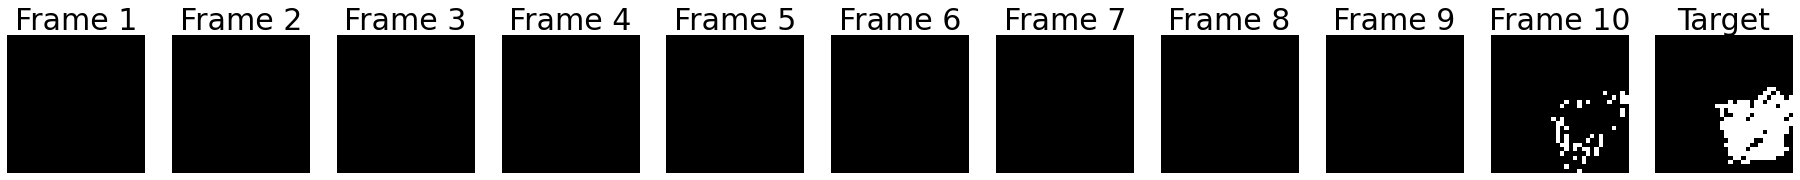

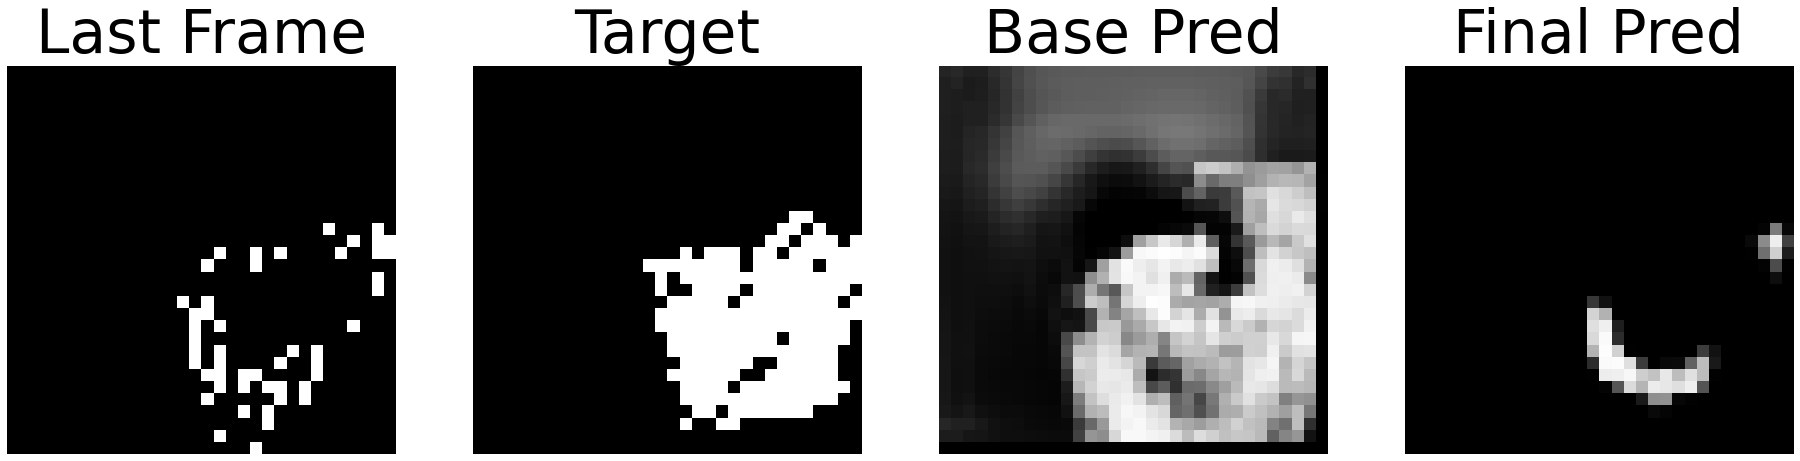

In [123]:
sample_idx = np.random.randint(0, len(x_val))

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
        ax.set_title('Target')
        ax.title.set_fontsize(30)
        ax.axis("off")
    else:
        ax.imshow(np.squeeze(x_val[sample_idx][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.title.set_fontsize(30)
        ax.axis("off")

fig, axes = plt.subplots(1, 4, figsize=(32, 16))
axes[0].imshow(np.squeeze(x_val[sample_idx][9]), cmap="gray")
axes[0].set_title('Last Frame')
axes[0].axis("off")
axes[0].title.set_fontsize(60)
axes[1].imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
axes[1].set_title('Target')
axes[1].axis("off")
axes[1].title.set_fontsize(60)
axes[2].imshow(np.squeeze(t_preds[sample_idx]), cmap="gray", vmin = 0, vmax = 1)
axes[2].set_title('Base Pred')
axes[2].axis("off")
axes[2].title.set_fontsize(60)
axes[3].imshow(np.squeeze(f_preds[sample_idx]), cmap="gray", vmin = 0, vmax = 1)
axes[3].set_title('Final Pred')
axes[3].axis("off")
axes[3].title.set_fontsize(60)

t_preds[sample_idx].min(), t_preds[sample_idx].max(), t_preds[sample_idx].mean(),
print('Sample Prediction Metrics:',
      '\nSample Number:', sample_idx,
      '\nSSIM | Base:', float(tf.image.ssim(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0)),
             '| Final:',float(tf.image.ssim(tf.cast(y_val[sample_idx], dtype='float32'), f_preds[sample_idx], 1.0)),
      '\nPSNR | Base:', float(tf.image.psnr(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0) / 100),
             '| Final:',float(tf.image.psnr(tf.cast(y_val[sample_idx], dtype='float32'), f_preds[sample_idx], 1.0) / 100),
      '\nMSE | Base:', np.mean(tf.keras.metrics.mean_squared_error(y_val[sample_idx], t_preds[sample_idx])),
            '| Final:',np.mean(tf.keras.metrics.mean_squared_error(y_val[sample_idx], f_preds[sample_idx])),
      '\nMin Px | Base:', t_preds[sample_idx].min(),
               '| Final:',f_preds[sample_idx].min(),
      '\nMax Px | Base:', t_preds[sample_idx].max(),
               '| Final:',f_preds[sample_idx].max(),
      '\nMean Px | Base:', t_preds[sample_idx].mean(),
                '| Final:',f_preds[sample_idx].mean()
     )

In [73]:
sample_idx

2196